# GAN_descriminator_test

* check if the descriminator is generalizable

In [1]:
# general tools
import sys
from glob import glob

# data tools
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import model_utils as mu
import train_utils as tu

In [2]:
import importlib
importlib.reload(mu)

<module 'model_utils' from '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/model_utils.py'>

# Global settings

In [3]:
sea = 'jja' # testing in the JJA season
N_input = 3 # LR T2, HR elev, LR elev
VAR = 'TMEAN'

N = [56, 112, 224, 448] # number of channels per downsampling level
l = [1e-4, 2e-4] # G lr; D lr

# Keras models

**Generator**, initialized with pre-trained UNET weights

In [4]:
# load weights
model_name = 'UNET3_{}_{}_tune'.format(VAR, sea)
model_path = temp_dir+model_name+'.hdf'
print('Import model: {}'.format(model_name))
backbone = keras.models.load_model(model_path)
W = backbone.get_weights()

# generator
G = mu.UNET(N, (None, None, N_input))
# optimizer
opt_G = keras.optimizers.Adam(lr=l[0])

print('Compiling G')
G.compile(loss=keras.losses.mean_absolute_error, optimizer=opt_G)
G.set_weights(W)

Import model: UNET3_TMEAN_jja_tune
Compiling G


**Descriminator**, pre-trained

In [5]:
# load weights
model_name = 'GAN_D_{}_{}'.format(VAR, sea)
model_path = temp_dir+model_name+'.hdf'

print('Import model: {}'.format(model_name))
backbone = keras.models.load_model(model_path)
W = backbone.get_weights()

input_size = (None, None, N_input+1)
D = mu.vgg_descriminator(N, input_size)

opt_D = keras.optimizers.Adam(lr=l[1])
print('Compiling D')
D.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt_D)
D.set_weights(W)

Import model: GAN_D_TMEAN_jja
Compiling D


**GAN**

In [6]:
GAN_IN = keras.layers.Input((None, None, N_input))
G_OUT = G(GAN_IN)
D_IN = keras.layers.Concatenate()([G_OUT, GAN_IN])
D_OUT = D(D_IN)
GAN = keras.models.Model(GAN_IN, [G_OUT, D_OUT])

print('Compiling GAN')
# content_loss + 1e-3 * adversarial_loss
GAN.compile(loss=[keras.losses.mean_absolute_error, keras.losses.categorical_crossentropy], 
            loss_weights=[1.0, 1e-3],
            optimizer=opt_G)

Compiling GAN


# Train domain test

In [7]:
file_path = BATCH_dir
trainfiles = glob(file_path+'{}_BATCH_*_TORI*_{}*.npy'.format(VAR, sea)) # e.g., TMAX_BATCH_128_VORIAUG_mam30.npy
# shuffle filenames
shuffle(trainfiles)
# 
L_train = len(trainfiles)

In [8]:
batch_size = 200

y_bad = np.zeros(batch_size)
y_good = np.ones(batch_size)
dummy_good = keras.utils.to_categorical(y_good)
dummy_mix = keras.utils.to_categorical(np.concatenate((y_bad, y_good), axis=0))

input_flag = [False, True, False, False, True, True] # LR T2, HR elev, LR elev
output_flag = [True, False, False, False, False, False] # HR T2
inout_flag = [True, True, False, False, True, True]
labels = ['batch', 'batch'] # input and output labels

In [9]:
LOSS_train = np.zeros(L_train)*np.nan
for i, name in enumerate(trainfiles):
    
    # import batch data
    temp_batch = np.load(name, allow_pickle=True)[()]
    X = temp_batch['batch'][...]
    
    # get G_output
    D.trainable = True
    g_in = X[..., input_flag]
    g_out = G.predict([g_in]) # <-- np.array
    
    # test D with G_output
    d_in_fake = np.concatenate((g_out, g_in), axis=-1) # channel last
    d_in_true = X[..., inout_flag]
    d_in = np.concatenate((d_in_fake, d_in_true), axis=0) # batch size doubled
    d_target = dummy_mix
    d_shuffle_ind = du.shuffle_ind(2*batch_size)
    LOSS_train[i] = D.evaluate(x=d_in[d_shuffle_ind, ...], 
                               y=d_target[d_shuffle_ind, ...], 
                               verbose=0)
    if i%100 == 0:
        print('progress: {}'.format(i))

progress: 0
progress: 100
progress: 200
progress: 300
progress: 400
progress: 500
progress: 600
progress: 700
progress: 800
progress: 900


In [10]:
print('Mean loss: {}'.format(np.mean(LOSS_train)))

Mean loss: 0.04987458013128234


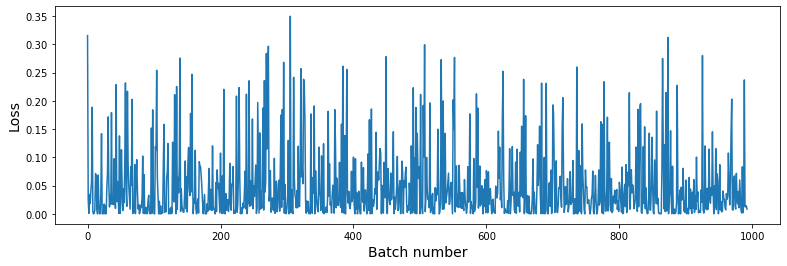

In [11]:
plt.figure(figsize=(13, 4))
plt.plot(LOSS_train)
plt.xlabel('Batch number', fontsize=14);
plt.ylabel('Loss', fontsize=14);

# Transferring domain test

In [12]:
transfiles = glob(file_path+'{}_BATCH_*_TSUB*_{}*.npy'.format(VAR, sea)) # e.g., TMAX_BATCH_128_VORIAUG_mam30.npy
# shuffle filenames
shuffle(transfiles)
# 
L_trans = len(transfiles)

In [13]:
LOSS_trans = np.zeros(L_trans)*np.nan

for i, name in enumerate(transfiles):
    
    # import batch data
    temp_batch = np.load(name, allow_pickle=True)[()]
    X = temp_batch['batch'][...]
    
    # get G_output
    D.trainable = True
    g_in = X[..., input_flag]
    g_out = G.predict([g_in]) # <-- np.array
    
    # test D with G_output
    d_in_fake = np.concatenate((g_out, g_in), axis=-1) # channel last
    d_in_true = X[..., inout_flag]
    d_in = np.concatenate((d_in_fake, d_in_true), axis=0) # batch size doubled
    d_target = dummy_mix
    d_shuffle_ind = du.shuffle_ind(2*batch_size)
    LOSS_trans[i] = D.evaluate(x=d_in[d_shuffle_ind, ...], 
                               y=d_target[d_shuffle_ind, ...], 
                               verbose=0)
    if i%100 == 0:
        print('progress: {}'.format(i))

progress: 0
progress: 100


In [14]:
print('Mean training domain loss: {}\nMean transferring domain loss: {}'.format(np.mean(LOSS_train), np.mean(LOSS_trans)))

Mean training domain loss: 0.04987458013128234
Mean transferring domain loss: 0.10281009960722015


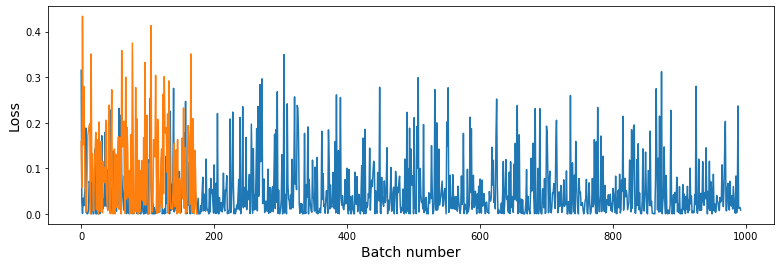

In [15]:
plt.figure(figsize=(13, 4))
plt.plot(LOSS_train)
plt.plot(LOSS_trans)
plt.xlabel('Batch number', fontsize=14);
plt.ylabel('Loss', fontsize=14);